# Credit

This notebook is based on the following notebook by @yasufuminakama. I would like to take this opportunity to thank him.

Please vote for his notebook as well.

https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Summary of this notebook

In this notebook, we are gonna build the nocall detector. (0:nocall, 1:somebird singing)

The output of the models would be probability value.

# input & output of this notebook

[input]

freefield1010 data

https://www.kaggle.com/startjapan/ff1010bird-duration7

[output]

Nocall detector models are outputted.

In [58]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [59]:
import torch

class CFG:
    print_freq=100
    num_workers=4
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=10
    lr=1e-4
    T_0=10 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-6
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    #device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

train = pd.read_csv('../input/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '../input/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '../input/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


In [61]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

!pip install timm
import timm

import warnings 
warnings.filterwarnings('ignore')

In [62]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [63]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df['hasbird'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        file_path = file_name
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [64]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [65]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

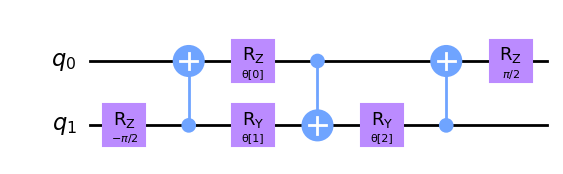

In [66]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

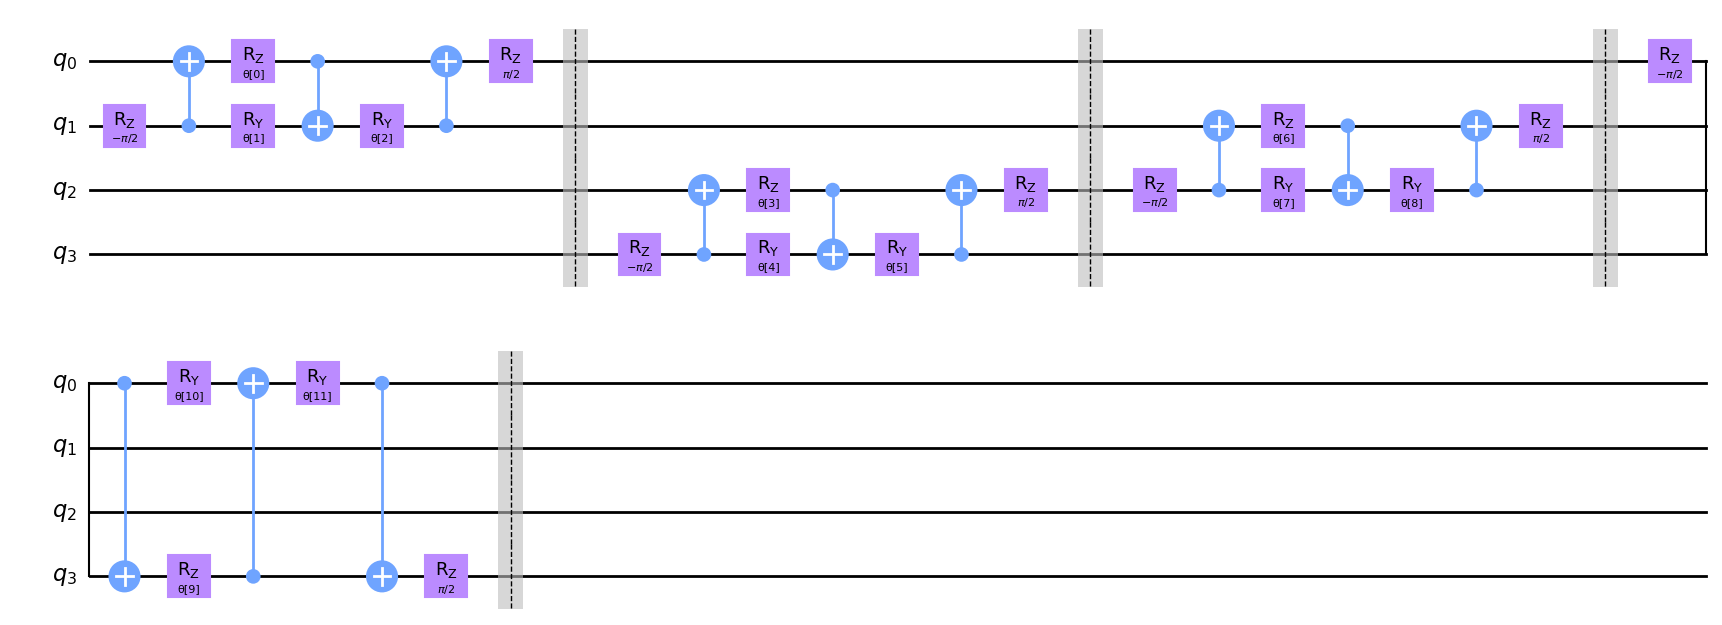

In [67]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

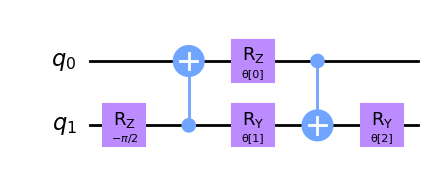

In [68]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

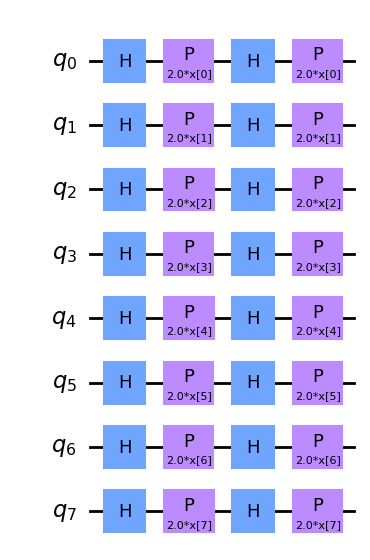

In [69]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl")

In [70]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

# we decompose the circuit for the QNN to avoid additional data copying
# Define and create QNN
nq=2
def create_qnn():
    feature_map = ZZFeatureMap(nq)
    ansatz = RealAmplitudes(nq, reps=1)
    qc = QuantumCircuit(nq)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [71]:
from qiskit_machine_learning.connectors import TorchConnector
from torch import cat, no_grad, manual_seed

In [72]:
class QuantumCustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.fc = nn.Linear(512, nq)    
        self.qnn = TorchConnector(qnn4)
        self.fc2 = nn.Linear(pow(2, nq), self.model.fc.in_features)
        
        # Remove fully connected layer and last two blocks
        self.model.fc = nn.Identity()
        self.model.layer4 = nn.Identity()
        self.model.layer3 = nn.Identity()

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.qnn(x)
        x = self.fc2(x)
        
        return x

In [73]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [74]:
from torchsummary import summary

def train_loop(train_folds, valid_folds):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = QuantumCustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.NLLLoss()
    best_score = 0.
    best_loss = np.inf
    
    summary(model, (3, 224, 224))
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores

In [75]:
def main(fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    def get_result2(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        matrix = get_confusion_matrix(labels, preds)
        print('TN', matrix[0,0])
        print('FP', matrix[0,1])
        print('FN', matrix[1,0])
        print('TP', matrix[1,1])
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_result2(oof_df)
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()

========== training ==========
========== training ==========
========== training ==========
========== training ==========


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
         Identity-10          [-1, 128, 56, 56]               0
             ReLU-11          [-1, 128, 56, 56]               0
         Identity-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          32,768
      BatchNorm2d-14          [-1, 256,

Epoch 1 - avg_train_loss: 0.0047  avg_val_loss: -0.0159  time: 148s
Epoch 1 - avg_train_loss: 0.0047  avg_val_loss: -0.0159  time: 148s
Epoch 1 - avg_train_loss: 0.0047  avg_val_loss: -0.0159  time: 148s
Epoch 1 - avg_train_loss: 0.0047  avg_val_loss: -0.0159  time: 148s
Epoch 1 - Accuracy: 0.0
Epoch 1 - Accuracy: 0.0
Epoch 1 - Accuracy: 0.0
Epoch 1 - Accuracy: 0.0


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 5s (remain 0m 0s) Loss: 0.1909(-0.0159) 
Epoch: [2][1/192] Data 0.267 (0.267) Elapsed 0m 1s (remain 4m 36s) Loss: -0.1159(-0.1159) Grad: 44.5211  
Epoch: [2][101/192] Data 0.000 (0.003) Elapsed 1m 11s (remain 1m 4s) Loss: -0.1324(-0.0684) Grad: 26.5513  
Epoch: [2][192/192] Data 0.000 (0.002) Elapsed 2m 15s (remain 0m 0s) Loss: -0.0799(-0.0837) Grad: 10.2585  
EVAL: [1/49] Data 0.125 (0.125) Elapsed 0m 0s (remain 0m 10s) Loss: -0.0137(-0.0137) 


Epoch 2 - avg_train_loss: -0.0837  avg_val_loss: -0.1135  time: 139s
Epoch 2 - avg_train_loss: -0.0837  avg_val_loss: -0.1135  time: 139s
Epoch 2 - avg_train_loss: -0.0837  avg_val_loss: -0.1135  time: 139s
Epoch 2 - avg_train_loss: -0.0837  avg_val_loss: -0.1135  time: 139s
Epoch 2 - Accuracy: 0.0
Epoch 2 - Accuracy: 0.0
Epoch 2 - Accuracy: 0.0
Epoch 2 - Accuracy: 0.0


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0668(-0.1135) 
Epoch: [3][1/192] Data 0.285 (0.285) Elapsed 0m 1s (remain 4m 46s) Loss: -0.2323(-0.2323) Grad: 7.9423  
Epoch: [3][101/192] Data 0.000 (0.003) Elapsed 1m 14s (remain 1m 7s) Loss: -0.1878(-0.1455) Grad: 10.7315  
Epoch: [3][192/192] Data 0.000 (0.002) Elapsed 2m 23s (remain 0m 0s) Loss: -0.0775(-0.1397) Grad: 16.0145  
EVAL: [1/49] Data 0.148 (0.148) Elapsed 0m 0s (remain 0m 13s) Loss: -0.0996(-0.0996) 


Epoch 3 - avg_train_loss: -0.1397  avg_val_loss: -0.1087  time: 149s
Epoch 3 - avg_train_loss: -0.1397  avg_val_loss: -0.1087  time: 149s
Epoch 3 - avg_train_loss: -0.1397  avg_val_loss: -0.1087  time: 149s
Epoch 3 - avg_train_loss: -0.1397  avg_val_loss: -0.1087  time: 149s
Epoch 3 - Accuracy: 0.0
Epoch 3 - Accuracy: 0.0
Epoch 3 - Accuracy: 0.0
Epoch 3 - Accuracy: 0.0


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0535(-0.1087) 
Epoch: [4][1/192] Data 0.362 (0.362) Elapsed 0m 1s (remain 4m 11s) Loss: -0.2471(-0.2471) Grad: 25.5877  
Epoch: [4][101/192] Data 0.000 (0.004) Elapsed 1m 18s (remain 1m 10s) Loss: -0.2043(-0.1711) Grad: 9.8891  
Epoch: [4][192/192] Data 0.000 (0.002) Elapsed 2m 26s (remain 0m 0s) Loss: -0.1798(-0.1755) Grad: 33.8674  
EVAL: [1/49] Data 0.135 (0.135) Elapsed 0m 0s (remain 0m 12s) Loss: -0.1618(-0.1618) 


Epoch 4 - avg_train_loss: -0.1755  avg_val_loss: -0.2032  time: 151s
Epoch 4 - avg_train_loss: -0.1755  avg_val_loss: -0.2032  time: 151s
Epoch 4 - avg_train_loss: -0.1755  avg_val_loss: -0.2032  time: 151s
Epoch 4 - avg_train_loss: -0.1755  avg_val_loss: -0.2032  time: 151s
Epoch 4 - Accuracy: 0.0
Epoch 4 - Accuracy: 0.0
Epoch 4 - Accuracy: 0.0
Epoch 4 - Accuracy: 0.0


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0903(-0.2032) 
Epoch: [5][1/192] Data 0.249 (0.249) Elapsed 0m 1s (remain 5m 1s) Loss: -0.2947(-0.2947) Grad: 31.4382  
Epoch: [5][101/192] Data 0.000 (0.003) Elapsed 1m 15s (remain 1m 8s) Loss: -0.3183(-0.2409) Grad: 25.2580  
Epoch: [5][192/192] Data 0.000 (0.002) Elapsed 2m 18s (remain 0m 0s) Loss: -0.2014(-0.2554) Grad: 28.5013  
EVAL: [1/49] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 11s) Loss: -0.2594(-0.2594) 


Epoch 5 - avg_train_loss: -0.2554  avg_val_loss: -0.2804  time: 142s
Epoch 5 - avg_train_loss: -0.2554  avg_val_loss: -0.2804  time: 142s
Epoch 5 - avg_train_loss: -0.2554  avg_val_loss: -0.2804  time: 142s
Epoch 5 - avg_train_loss: -0.2554  avg_val_loss: -0.2804  time: 142s
Epoch 5 - Accuracy: 0.0
Epoch 5 - Accuracy: 0.0
Epoch 5 - Accuracy: 0.0
Epoch 5 - Accuracy: 0.0


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0425(-0.2804) 
Epoch: [6][1/192] Data 0.288 (0.288) Elapsed 0m 1s (remain 4m 11s) Loss: -0.3992(-0.3992) Grad: 11.2567  
Epoch: [6][101/192] Data 0.000 (0.003) Elapsed 1m 6s (remain 0m 59s) Loss: -0.3907(-0.3065) Grad: 18.1531  
Epoch: [6][192/192] Data 0.000 (0.002) Elapsed 2m 5s (remain 0m 0s) Loss: -0.2607(-0.3104) Grad: 7.9148  
EVAL: [1/49] Data 0.121 (0.121) Elapsed 0m 0s (remain 0m 10s) Loss: -0.2806(-0.2806) 


Epoch 6 - avg_train_loss: -0.3104  avg_val_loss: -0.3217  time: 130s
Epoch 6 - avg_train_loss: -0.3104  avg_val_loss: -0.3217  time: 130s
Epoch 6 - avg_train_loss: -0.3104  avg_val_loss: -0.3217  time: 130s
Epoch 6 - avg_train_loss: -0.3104  avg_val_loss: -0.3217  time: 130s
Epoch 6 - Accuracy: 0.0
Epoch 6 - Accuracy: 0.0
Epoch 6 - Accuracy: 0.0
Epoch 6 - Accuracy: 0.0


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: -0.0882(-0.3217) 
Epoch: [7][1/192] Data 0.252 (0.252) Elapsed 0m 1s (remain 3m 50s) Loss: -0.4461(-0.4461) Grad: 19.3910  
Epoch: [7][101/192] Data 0.000 (0.003) Elapsed 1m 10s (remain 1m 3s) Loss: -0.4189(-0.3411) Grad: 9.2579  
Epoch: [7][192/192] Data 0.000 (0.001) Elapsed 2m 14s (remain 0m 0s) Loss: -0.2782(-0.3385) Grad: 34.8788  
EVAL: [1/49] Data 0.120 (0.120) Elapsed 0m 0s (remain 0m 11s) Loss: -0.2889(-0.2889) 


Epoch 7 - avg_train_loss: -0.3385  avg_val_loss: -0.3281  time: 138s
Epoch 7 - avg_train_loss: -0.3385  avg_val_loss: -0.3281  time: 138s
Epoch 7 - avg_train_loss: -0.3385  avg_val_loss: -0.3281  time: 138s
Epoch 7 - avg_train_loss: -0.3385  avg_val_loss: -0.3281  time: 138s
Epoch 7 - Accuracy: 0.0
Epoch 7 - Accuracy: 0.0
Epoch 7 - Accuracy: 0.0
Epoch 7 - Accuracy: 0.0


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: -0.0128(-0.3281) 
Epoch: [8][1/192] Data 0.250 (0.250) Elapsed 0m 1s (remain 5m 37s) Loss: -0.4613(-0.4613) Grad: 19.5487  
Epoch: [8][101/192] Data 0.000 (0.003) Elapsed 1m 11s (remain 1m 4s) Loss: -0.4346(-0.3628) Grad: 52.3278  
Epoch: [8][192/192] Data 0.000 (0.001) Elapsed 2m 13s (remain 0m 0s) Loss: -0.3007(-0.3640) Grad: 58.3515  
EVAL: [1/49] Data 0.111 (0.111) Elapsed 0m 0s (remain 0m 11s) Loss: -0.3160(-0.3160) 


Epoch 8 - avg_train_loss: -0.3640  avg_val_loss: -0.3491  time: 138s
Epoch 8 - avg_train_loss: -0.3640  avg_val_loss: -0.3491  time: 138s
Epoch 8 - avg_train_loss: -0.3640  avg_val_loss: -0.3491  time: 138s
Epoch 8 - avg_train_loss: -0.3640  avg_val_loss: -0.3491  time: 138s
Epoch 8 - Accuracy: 0.0
Epoch 8 - Accuracy: 0.0
Epoch 8 - Accuracy: 0.0
Epoch 8 - Accuracy: 0.0


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: -0.0412(-0.3491) 
Epoch: [9][1/192] Data 0.306 (0.306) Elapsed 0m 1s (remain 4m 5s) Loss: -0.4509(-0.4509) Grad: 30.6137  
Epoch: [9][101/192] Data 0.000 (0.003) Elapsed 1m 8s (remain 1m 1s) Loss: -0.4433(-0.3798) Grad: 62.7554  
Epoch: [9][192/192] Data 0.000 (0.002) Elapsed 2m 8s (remain 0m 0s) Loss: -0.3070(-0.3781) Grad: 13.5226  
EVAL: [1/49] Data 0.129 (0.129) Elapsed 0m 0s (remain 0m 11s) Loss: -0.3207(-0.3207) 


Epoch 9 - avg_train_loss: -0.3781  avg_val_loss: -0.3600  time: 133s
Epoch 9 - avg_train_loss: -0.3781  avg_val_loss: -0.3600  time: 133s
Epoch 9 - avg_train_loss: -0.3781  avg_val_loss: -0.3600  time: 133s
Epoch 9 - avg_train_loss: -0.3781  avg_val_loss: -0.3600  time: 133s
Epoch 9 - Accuracy: 0.0
Epoch 9 - Accuracy: 0.0
Epoch 9 - Accuracy: 0.0
Epoch 9 - Accuracy: 0.0


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: -0.0499(-0.3600) 
Epoch: [10][1/192] Data 0.265 (0.265) Elapsed 0m 1s (remain 3m 42s) Loss: -0.4713(-0.4713) Grad: 34.7774  
Epoch: [10][101/192] Data 0.000 (0.003) Elapsed 1m 10s (remain 1m 3s) Loss: -0.4564(-0.3864) Grad: 54.0686  
Epoch: [10][192/192] Data 0.000 (0.002) Elapsed 2m 14s (remain 0m 0s) Loss: -0.3079(-0.3855) Grad: 17.8691  
EVAL: [1/49] Data 0.132 (0.132) Elapsed 0m 0s (remain 0m 10s) Loss: -0.3263(-0.3263) 


Epoch 10 - avg_train_loss: -0.3855  avg_val_loss: -0.3637  time: 138s
Epoch 10 - avg_train_loss: -0.3855  avg_val_loss: -0.3637  time: 138s
Epoch 10 - avg_train_loss: -0.3855  avg_val_loss: -0.3637  time: 138s
Epoch 10 - avg_train_loss: -0.3855  avg_val_loss: -0.3637  time: 138s
Epoch 10 - Accuracy: 0.0
Epoch 10 - Accuracy: 0.0
Epoch 10 - Accuracy: 0.0
Epoch 10 - Accuracy: 0.0


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: -0.0625(-0.3637) 


========== CV ==========
========== CV ==========
========== CV ==========
========== CV ==========
Score: 0.88557
Score: 0.88557
Score: 0.88557
Score: 0.88557


TN 1117
FP 34
FN 142
TP 245


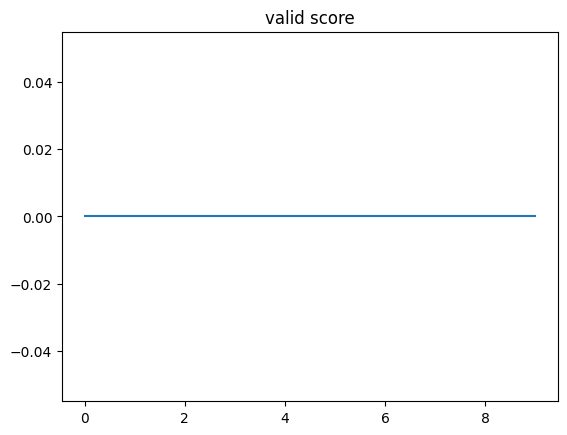

In [76]:
if __name__ == '__main__':
    main(0)